# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [ ]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [ ]:
filename="../Lab.7/SUSY-small.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

In [ ]:
print(df.shape)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [4]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### Exercise 2: Read About Classifiers

#### Part a|
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [30]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [32]:
#N_Train=4000000
N_Train = int((0.8) * len(df)) # use 80% for training
Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [ ]:
Fisher.fit(X_Train,y_Train)

We can plot the output, comparing signal and background:

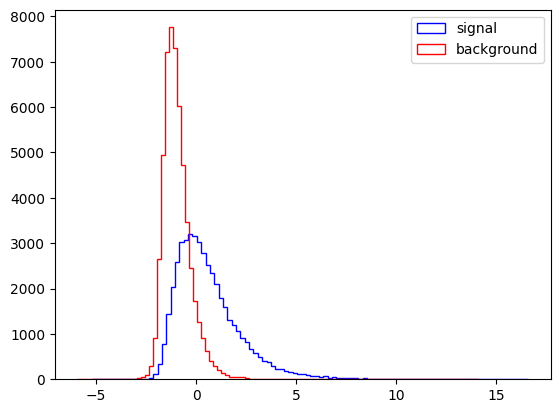

In [34]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

In [36]:
#PART a
from sklearn.metrics import roc_curve, auc

# Compute ROC curve for training sample
fpr_train, tpr_train, _ = roc_curve(y_Train, Fisher.decision_function(X_Train))
roc_auc_train = auc(fpr_train, tpr_train)

In [37]:
# Compute ROC curve for TEST sample
fpr_test, tpr_test, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))
roc_auc_test = auc(fpr_test, tpr_test)

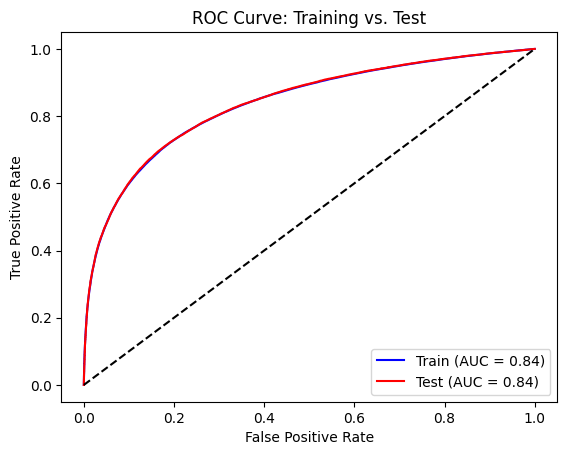

In [39]:
# Plot both curves
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Training vs. Test')
plt.legend(loc='lower right')
plt.show()

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

In [47]:
# define input sets
RawNames = ["l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames = list(set(VarNames[1:]) - set(RawNames))  # Derived features

In [48]:
# input combinations
X_Train_raw = Train_Sample[RawNames]
X_Train_features = Train_Sample[FeatureNames]
X_Train_both = Train_Sample[VarNames[1:]]  # Raw + Features

In [49]:
# train 3 LDAs
Fisher_raw = DA.LinearDiscriminantAnalysis().fit(X_Train_raw, y_Train)
Fisher_features = DA.LinearDiscriminantAnalysis().fit(X_Train_features, y_Train)
Fisher_both = DA.LinearDiscriminantAnalysis().fit(X_Train_both, y_Train)


In [50]:
# compute ROC curves for test sample
fpr_raw, tpr_raw, _ = roc_curve(y_Test, Fisher_raw.decision_function(X_Test[RawNames]))
fpr_features, tpr_features, _ = roc_curve(y_Test, Fisher_features.decision_function(X_Test[FeatureNames]))
fpr_both, tpr_both, _ = roc_curve(y_Test, Fisher_both.decision_function(X_Test[VarNames[1:]]))

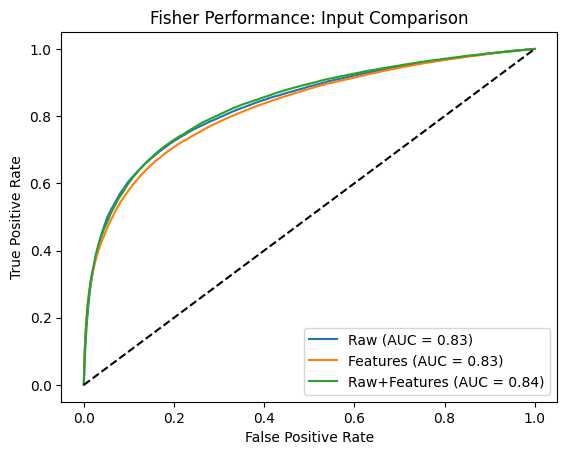

In [51]:
# Plot all curves
plt.figure()
plt.plot(fpr_raw, tpr_raw, label=f'Raw (AUC = {auc(fpr_raw, tpr_raw):.2f})')
plt.plot(fpr_features, tpr_features, label=f'Features (AUC = {auc(fpr_features, tpr_features):.2f})')
plt.plot(fpr_both, tpr_both, label=f'Raw+Features (AUC = {auc(fpr_both, tpr_both):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fisher Performance: Input Comparison')
plt.legend(loc='lower right')
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.


In [ ]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% test)
X = df[VarNames[1:]]
y = df["signal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize classifiers
clf_lr = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_svm = SVC(kernel='rbf', probability=True, random_state=42)  # Enable probability for ROC

# Train
clf_lr.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)

In [ ]:
# Get predicted probabilities for test set
y_prob_lr = clf_lr.predict_proba(X_test)[:, 1]
y_prob_rf = clf_rf.predict_proba(X_test)[:, 1]
y_prob_svm = clf_svm.predict_proba(X_test)[:, 1]

# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)

# Plot
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc(fpr_lr, tpr_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc(fpr_svm, tpr_svm):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Comparison: ROC Curves')
plt.legend(loc='lower right')
plt.show()

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.


#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 7.

### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 
